In [1]:
import rasterio
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
from rasterio import mask
from earthpy.spatial import stack as es_stack
from earthpy.spatial import crop_image
from glob import glob
from scipy.stats import linregress
from skimage.measure import block_reduce


import warnings
warnings.filterwarnings("ignore")

import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}	
matplotlib.rc('font', **font)

matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)

In [2]:
aoi = gpd.read_file('../arcgis_pro/goldhill/sample_aoi.shp')

aoi.crs

{'init': 'epsg:32613'}

In [3]:
ms_drone_im = '../arcgis_pro/goldhill/redo_MS_goldhill_switzerl.tif'
with rasterio.open(ms_drone_im) as src:
    
    ms_full_prof = src.profile
    ms_arr, ms_prof = mask.mask(src, shapes=aoi['geometry'], crop=True, all_touched=True, nodata=ms_full_prof['nodata'])
    
    ms_arr = np.ma.masked_equal(ms_arr, ms_full_prof['nodata'])
    # mask nodata

In [19]:
ms_full_prof['transform']

Affine(0.035247651661553935, 0.0, 461120.79504111357,
       0.0, -0.03524813528867955, 4433336.16202332)

In [4]:
# planet image
planet_im_sd = '../planet/sd_family/20200107_174113_04_106e/20200107_174113_04_106e_3B_AnalyticMS_SR.tif'
planet_im_3b = '../planet/20200125_154827_0f49/20200125_154827_0f49_3B_AnalyticMS_SR.tif'

with rasterio.open(planet_im_sd) as src:
    
    pl_sd_full_prof = src.profile
    pl_sd_arr, pl_sd_prof = mask.mask(src, shapes=aoi['geometry'], crop=True, all_touched=True, nodata=pl_sd_full_prof['nodata'])
    
    pl_sd_arr = np.ma.masked_equal(pl_sd_arr, pl_sd_full_prof['nodata'])
    # mask nodata

with rasterio.open(planet_im_3b) as src:
    
    pl_3b_full_prof = src.profile
    pl_3b_arr, pl_sd_prof = mask.mask(src, shapes=aoi['geometry'], crop=True, all_touched=True, nodata=pl_3b_full_prof['nodata'])
    
    pl_3b_arr = np.ma.masked_equal(pl_3b_arr, pl_3b_full_prof['nodata'])
    

In [21]:
pl_sd_full_prof, pl_sd_prof

({'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 9501, 'height': 7260, 'count': 4, 'crs': CRS.from_dict(init='epsg:32613'), 'transform': Affine(3.0, 0.0, 457977.0,
        0.0, -3.0, 4446900.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'},
 Affine(3.0, 0.0, 461172.0,
        0.0, -3.0, 4433253.0))

In [5]:
#  import landsat and stack
l8_sr_dir = '../landsat/LC080340322020012401T1-SC20200128182901/'
l8_files = glob(l8_sr_dir + '*sr_band*.tif')
l8_files, 'Surface Reflectance_LC08_L1TP_034032_20200124_20200128_01_T1'

(['../landsat/LC080340322020012401T1-SC20200128182901\\LC08_L1TP_034032_20200124_20200128_01_T1_sr_band1.tif',
  '../landsat/LC080340322020012401T1-SC20200128182901\\LC08_L1TP_034032_20200124_20200128_01_T1_sr_band2.tif',
  '../landsat/LC080340322020012401T1-SC20200128182901\\LC08_L1TP_034032_20200124_20200128_01_T1_sr_band3.tif',
  '../landsat/LC080340322020012401T1-SC20200128182901\\LC08_L1TP_034032_20200124_20200128_01_T1_sr_band4.tif',
  '../landsat/LC080340322020012401T1-SC20200128182901\\LC08_L1TP_034032_20200124_20200128_01_T1_sr_band5.tif',
  '../landsat/LC080340322020012401T1-SC20200128182901\\LC08_L1TP_034032_20200124_20200128_01_T1_sr_band6.tif',
  '../landsat/LC080340322020012401T1-SC20200128182901\\LC08_L1TP_034032_20200124_20200128_01_T1_sr_band7.tif'],
 'Surface Reflectance_LC08_L1TP_034032_20200124_20200128_01_T1')

In [6]:
l8_arr_list = []
for fi in l8_files:
    
    with rasterio.open(fi) as src:
        l8_prof = src.profile
        _arr, l8_crop_prof = mask.mask(src, shapes=aoi['geometry'], crop=True, all_touched=True, nodata=l8_prof['nodata'])
        
        l8_arr_list.append(_arr[0])
        
    l8_arr = np.array(l8_arr_list)
    l8_arr = np.ma.masked_equal(l8_arr, l8_prof['nodata'])
    

## calculate and mask NDVI

In [7]:
ndvi_l8 = (l8_arr[4] - l8_arr[3]) / (l8_arr[4] + l8_arr[3])
ndvi_l8 = np.ma.where(ndvi_l8 > 1.0, np.nan, ndvi_l8)

ndvi_pl_sd = (pl_sd_arr[3] - pl_sd_arr[2]) / (pl_sd_arr[3] + pl_sd_arr[2])
ndvi_pl_sd = np.ma.where(ndvi_pl_sd > 1.0, np.nan, ndvi_pl_sd)

ndvi_pl_3b = (pl_3b_arr[3] - pl_3b_arr[2]) / (pl_3b_arr[3] + pl_3b_arr[2])
ndvi_pl_3b = np.ma.where(ndvi_pl_3b > 1.0, np.nan, ndvi_pl_3b)

ndvi_kernel = (ms_arr[4] - ms_arr[2]) / (ms_arr[4] + ms_arr[2])
ndvi_kernel = np.ma.where(np.ma.abs(ndvi_kernel) > 1.0, np.nan, ndvi_kernel)


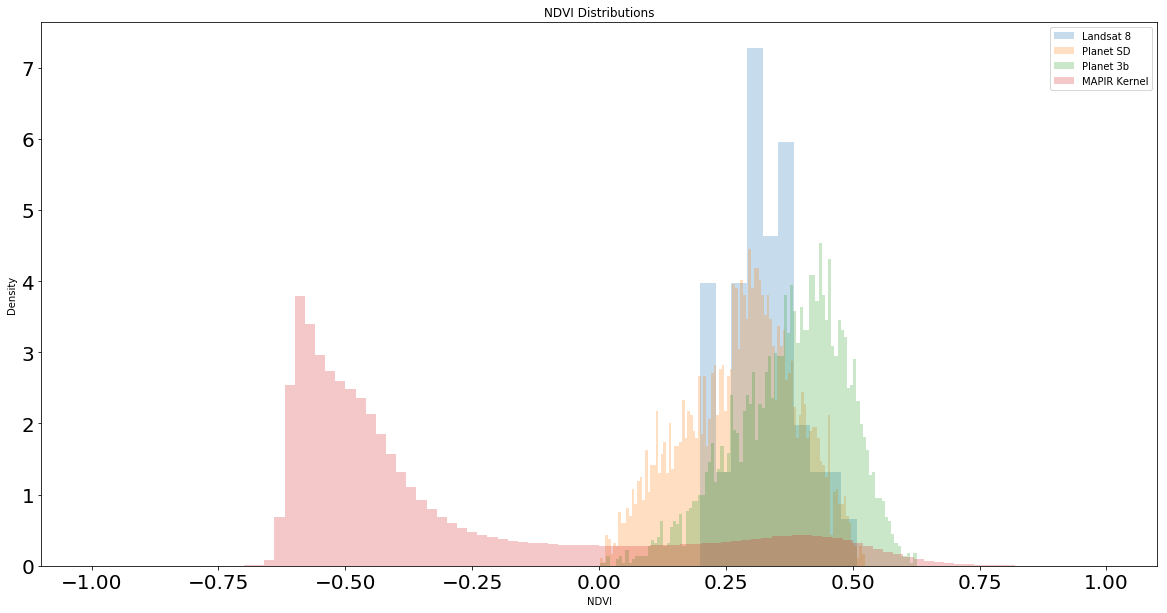

In [8]:
plt.figure(figsize=(20,10))
alpha_val = 0.25
plt.hist(ndvi_l8.ravel(), bins=10, density=True, alpha=alpha_val, label='Landsat 8');
plt.hist(ndvi_pl_sd.ravel(), bins=100, density=True, alpha=alpha_val, label='Planet SD');
plt.hist(ndvi_pl_3b.ravel(), bins=100, density=True, alpha=alpha_val, label='Planet 3b');
plt.hist(ndvi_kernel.ravel(), bins=100, density=True, alpha=alpha_val, label='MAPIR Kernel');
plt.legend()
plt.title('NDVI Distributions')
plt.xlabel('NDVI')
plt.ylabel('Density')
plt.show()

## Have a look at the NDVI across the full range of values

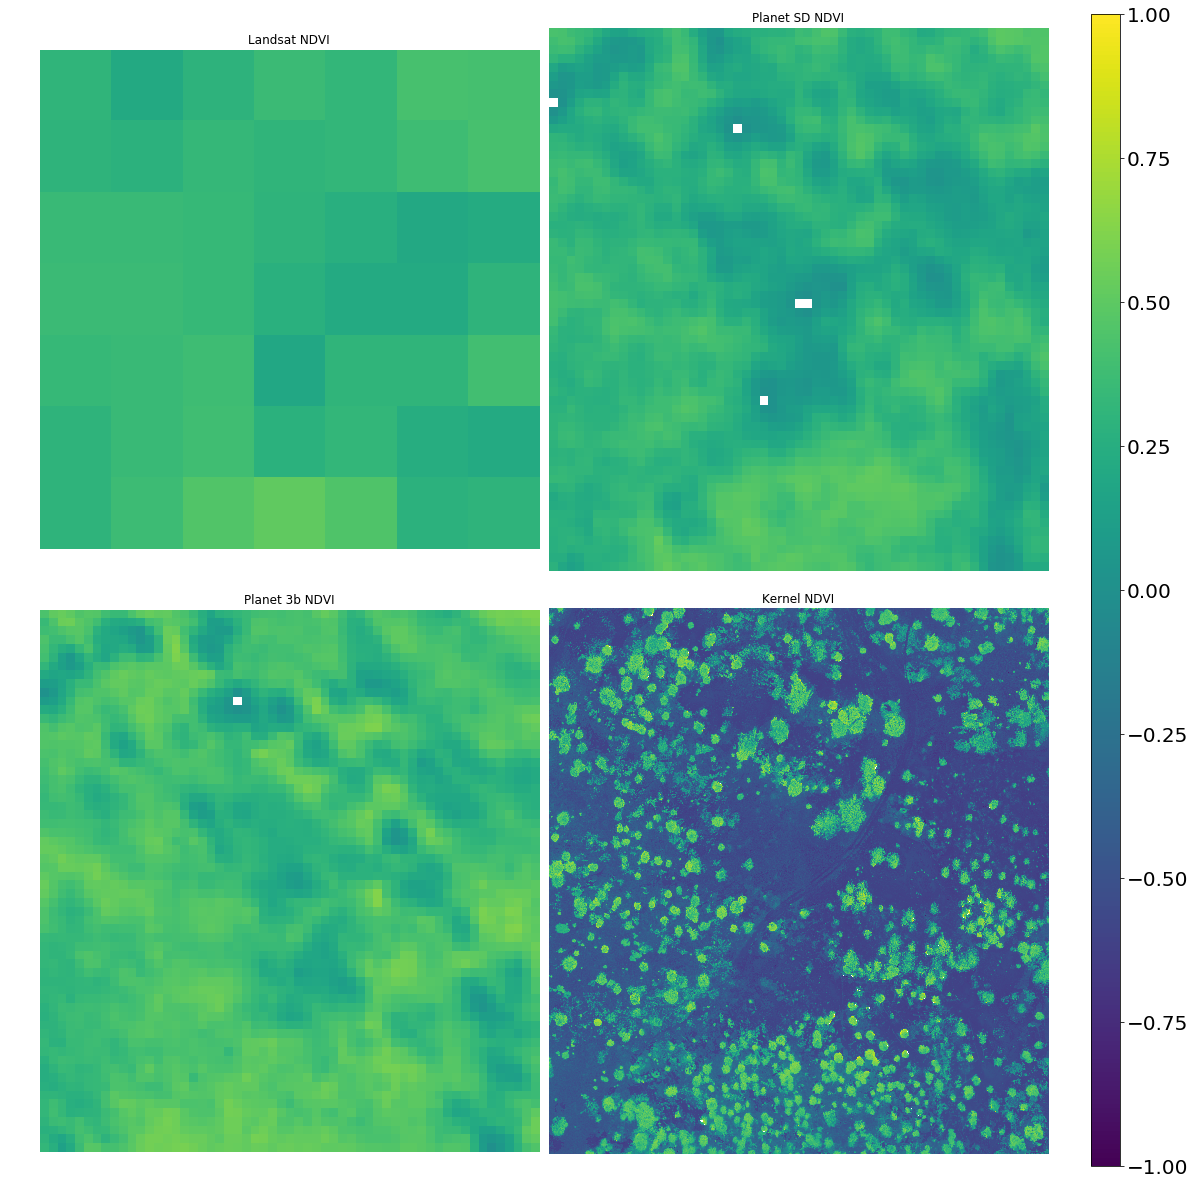

In [9]:
fig, ax = plt.subplots(2,2, figsize=(20,20))
axes=ax.ravel()
title=['Landsat NDVI', 'Planet SD NDVI', 'Planet 3b NDVI', 'Kernel NDVI']
for i, arr in enumerate([ndvi_l8, ndvi_pl_sd, ndvi_pl_3b, ndvi_kernel]):
    
    axes[i].axis('off')
    axes[i].set_title(title[i])
    im = axes[i].imshow(arr, vmin=-1., vmax=1.)
    

# adjust for colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)


plt.show()

## Where is this large influence of lower NIR values coming from in the Kernel data?

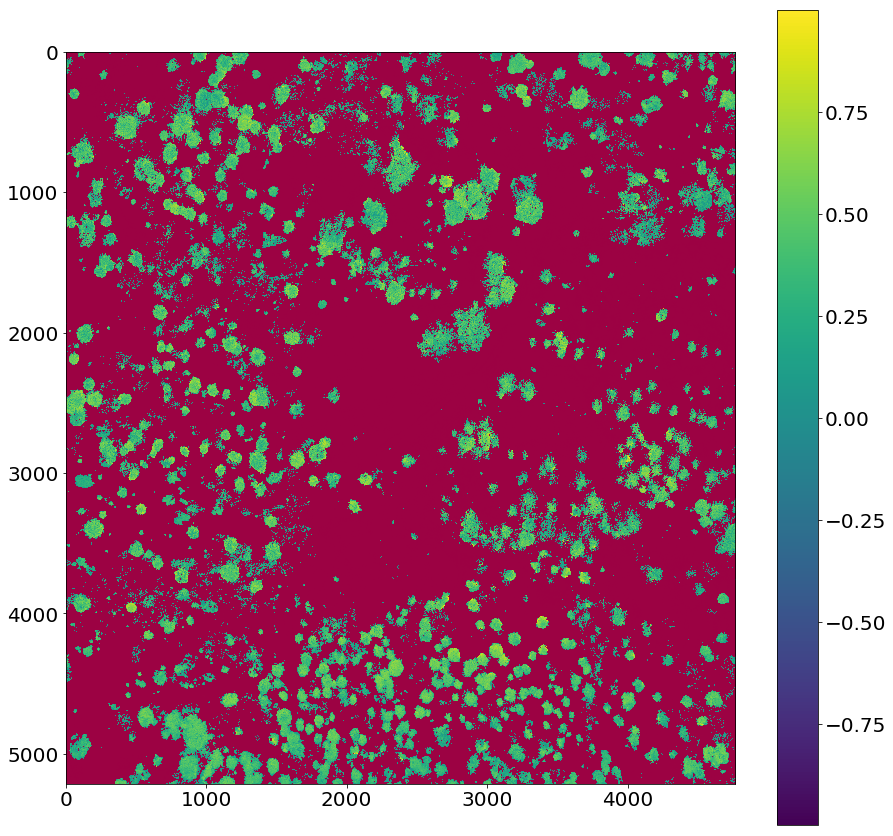

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(ndvi_kernel)
plt.colorbar()
plt.imshow(np.ma.masked_where(ndvi_kernel > 0, np.ones(ndvi_kernel.shape)), alpha=0.99, cmap='Spectral') # map pixels < 0
plt.show()


## SNOW

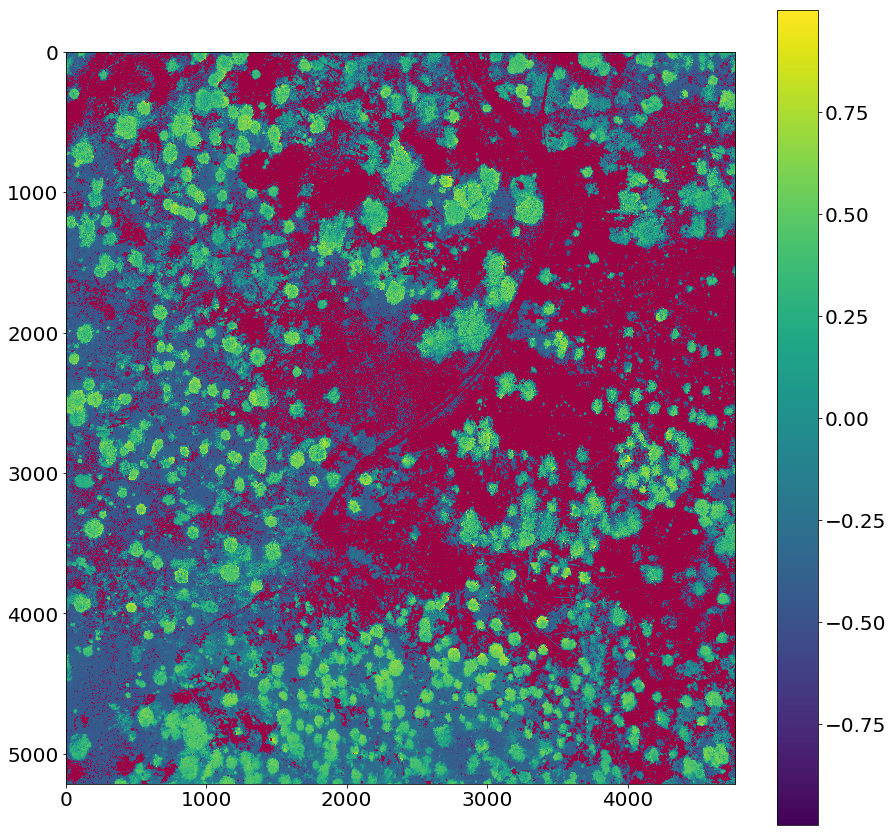

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(ndvi_kernel)
plt.colorbar()
plt.imshow(np.ma.masked_where(ndvi_kernel > -0.50, np.ones(ndvi_kernel.shape)), alpha=0.99, cmap='Spectral') # map pixels < 0
plt.show()


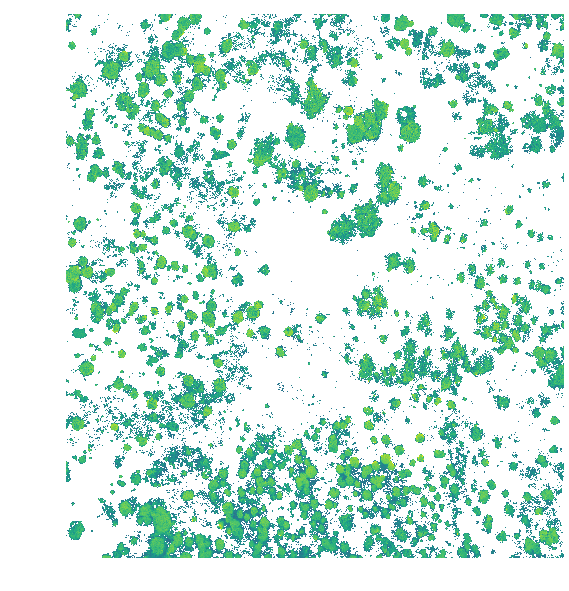

In [12]:
snow_thresh = -0.25
masked_ndvi = np.ma.masked_where(ndvi_kernel < snow_thresh, ndvi_kernel)

plt.figure(figsize=(10,10))
plt.imshow(masked_ndvi, vmin=-1, vmax=1.)
plt.axis('off');

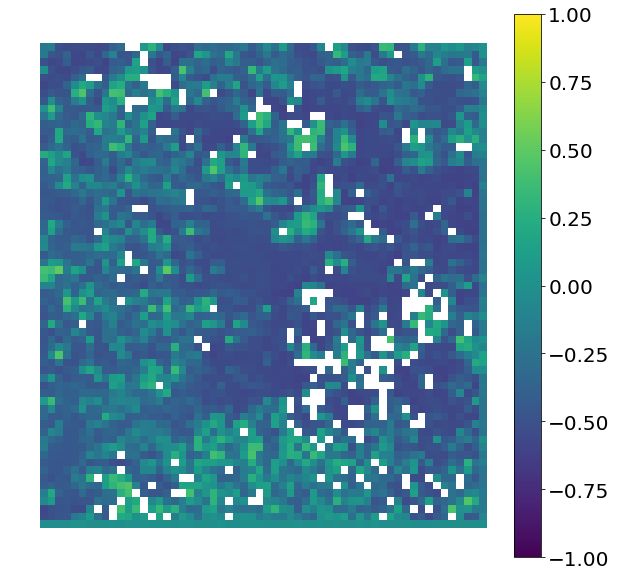

In [13]:
pl_rowf = ndvi_kernel.shape[0] // ndvi_pl_sd.shape[0]
pl_colf = ndvi_kernel.shape[1] // ndvi_pl_sd.shape[1]

masked_sum = block_reduce(masked_ndvi, (pl_rowf, pl_colf), np.ma.sum)
masked_count = block_reduce(masked_ndvi, (pl_rowf, pl_colf), np.ma.count)
masked_ndvi_kernel_pl = masked_sum / masked_count

masked_ndvi_kernel_pl = block_reduce(masked_ndvi, (pl_rowf, pl_colf), np.ma.mean)

plt.figure(figsize=(10,10))
plt.imshow(masked_ndvi_kernel_pl, vmin=-1, vmax=1.)
plt.colorbar()
plt.axis('off')
plt.show()

### implement 2D gaussian for block reduce

(<matplotlib.image.AxesImage at 0x2db0e2ee780>,
 188.15325783425953)

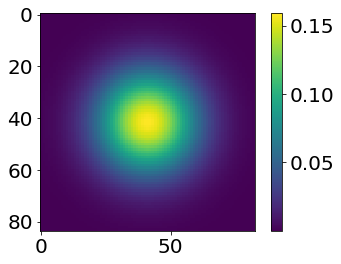

In [14]:
# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

st = 3
x = np.linspace(-st, st, pl_colf)
y = np.linspace(-st, st, pl_rowf)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D

spread = 1
z = gaus2d(x, y, sx=spread, sy=spread)
# z/=z.sum()

plt.imshow(z), plt.colorbar(), z.sum()

In [15]:
z_ones = np.ones(z.shape)

(z_ones * z).sum() / z.sum()

1.0

In [16]:
4/36 + 8/18 + 4/9

1.0

In [17]:
pl_rowf = ndvi_kernel.shape[0] // ndvi_pl_sd.shape[0]
pl_colf = ndvi_kernel.shape[1] // ndvi_pl_sd.shape[1]
kernel_pl_nir = block_reduce(ms_arr[-2], (pl_rowf, pl_colf), gauss_reduce)
kernel_pl_red = block_reduce(ms_arr[-4], (pl_rowf, pl_colf), gauss_reduce)

#ndvi_kernel_pl = (kernel_pl_nir - kernel_pl_red) / (kernel_pl_nir + kernel_pl_red)

NameError: name 'gauss_reduce' is not defined

In [ ]:
# plt.imshow(ndvi_kernel_pl)
ndvi_kernel_pl, kernel_pl_nir

In [ ]:
# implement manually...
def gauss_reducer(arr, zk, rowf, colf, newshape):

    a = np.zeros(newshape)
    for ix, i in enumerate(range(0, arr.shape[0], rowf)):
        for jx, j in enumerate(range(0, arr.shape[1], colf)):

            row_start = i
            row_end = i+pl_rowf

            col_start = j
            col_end = j+pl_colf

            
            try:
                sub_im = arr[row_start:row_end, col_start:col_end]
                sub_im *= zk

                a[ix,jx] = sub_im.sum() / z.sum()
                

            except:
                continue
                
    return a

In [ ]:
red_gauss = gauss_reducer(ms_arr[2], z, pl_rowf, pl_colf, ndvi_pl_sd.shape)
nir_gauss = gauss_reducer(ms_arr[4], z, pl_rowf, pl_colf, ndvi_pl_sd.shape)

plt.figure(figsize=(5,5))
plt.imshow(red_gauss)
plt.colorbar()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(nir_gauss);
plt.colorbar()
plt.show()

ndvi_gauss = (nir_gauss - red_gauss) / (nir_gauss + red_gauss)
plt.figure(figsize=(5,5))
plt.imshow(ndvi_gauss)
plt.colorbar()
plt.show()


In [ ]:
plt.scatter(ndvi_gauss.ravel(), ndvi_pl_sd.ravel())

In [ ]:
w = np.array([[1/36, 1/18, 1/18, 1/36],
              [1/18, 1/9, 1/9, 1/18],
              [1/18, 1/9, 1/9, 1/18],
              [1/36, 1/18, 1/18, 1/36]])

samp = np.array([[0.1,0.15,0.15,0.2],
                [0.1,0.133,0.12,0.02],
                [0.16,0.13,0.3,0.23],
                [0.18,0.05,0.12,0.24]])
plt.imshow(w)
plt.show()
plt.imshow(samp)

In [ ]:
(samp*w).sum()/w.sum()

## looks like the Kernel Camera NDVI is different because of the very high resolution and pure pixels on the lower side of NDVI. Mask the NDVI < -0.5 and do the block reduce

In [ ]:
masked_kernel_ndvi = ndvi_kernel[ndvi_kernel>0]

plt.figure(figsize=(20,10))
alpha_val = 0.25
plt.hist(ndvi_l8.ravel(), bins=10, density=True, alpha=alpha_val, label='Landsat 8');
plt.hist(ndvi_pl_sd.ravel(), bins=100, density=True, alpha=alpha_val, label='Planet SD');
plt.hist(ndvi_pl_3b.ravel(), bins=100, density=True, alpha=alpha_val, label='Planet 3b');
plt.hist(masked_kernel_ndvi, bins=100, density=True, alpha=alpha_val, label='MAPIR Kernel');
plt.legend()
plt.title('NDVI Distributions')
plt.xlabel('NDVI')
plt.ylabel('Density')
plt.show()

## Resample Kernel image using Block Reduce from skimage

In [ ]:
from skimage.measure import block_reduce

In [ ]:
pl_rowf = ndvi_kernel.shape[0] // ndvi_pl_sd.shape[0]
pl_colf = ndvi_kernel.shape[1] // ndvi_pl_sd.shape[1]
kernel_pl_nir = block_reduce(ms_arr[-2], (pl_rowf, pl_colf), np.mean)
kernel_pl_red = block_reduce(ms_arr[-4], (pl_rowf, pl_colf), np.mean)

ndvi_kernel_pl = (kernel_pl_nir - kernel_pl_red) / (kernel_pl_nir + kernel_pl_red)

In [ ]:
plt.imshow(ndvi_kernel_pl, vmin=-1., vmax=1.)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,20))
axes=ax.ravel()
title=['Landsat NDVI', 'Planet SD NDVI', 'Planet 3b NDVI', 'Planet Resampled Kernel NDVI']
for i, arr in enumerate([ndvi_l8, ndvi_pl_sd, ndvi_pl_3b, ndvi_kernel_pl]):
    
    axes[i].axis('off')
    axes[i].set_title(title[i])
    im = axes[i].imshow(arr, vmin=-1., vmax=1.)
    

# adjust for colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)


plt.show()

In [ ]:
plt.scatter(ndvi_kernel_pl[1:,1:].ravel(), ndvi_pl_sd.ravel())
# ndvi_kernel_pl.shape, ndvi_pl_sd.shape

In [ ]:
print(f'Original Kernel pixel size: {ms_prof.a:.4f} m')
print(f'Resampled Kernel pixel size: {ms_prof.a*pl_rowf:.4f} m')

## check the standard deviation of pixels in each block

In [ ]:
kernel_pl_nir_std = block_reduce(ms_arr[-2], (pl_rowf, pl_colf), np.std)
kernel_pl_red_std = block_reduce(ms_arr[2], (pl_rowf, pl_colf), np.std)

plt.figure(figsize=(10,10))
plt.imshow(kernel_pl_nir_std)
plt.colorbar()
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(kernel_pl_red_std)
plt.colorbar()
plt.axis('off')
plt.show()

## look at the different resampling techniques for skimage resize

In [ ]:
for interp in range(5):

    print(f"*********************** RESAMPLING = {interp} ************************")
#     interp = 0
    red_resize_pl = resize(ms_arr[2], ndvi_pl_sd.shape, order=interp)
    nir_resize_pl = resize(ms_arr[4], ndvi_pl_sd.shape, order=interp)

    ndvi_resize_pl = (nir_resize_pl - red_resize_pl) / (nir_resize_pl + red_resize_pl)

    fig, ax = plt.subplots(2,2, figsize=(20,20))
    axes=ax.ravel()
    title=['Landsat NDVI', 'Planet SD NDVI', 'Planet 3b NDVI', 'Planet SD Resized Kernel NDVI']
    for i, arr in enumerate([ndvi_l8, ndvi_pl_sd, ndvi_pl_3b, ndvi_resize_pl]):

        axes[i].axis('off')
        axes[i].set_title(title[i])
        im = axes[i].imshow(arr, vmin=-1., vmax=1.)


    # adjust for colorbar
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                        wspace=0.02, hspace=0.02)

    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(im, cax=cb_ax)


    plt.show()

    plt.scatter(ndvi_resize_pl.ravel(), ndvi_pl_sd.ravel())
    slope, intercept, rvalue, pvalue, stderr = linregress(ndvi_resize_pl.ravel(), ndvi_pl_sd.ravel())
    plt.plot(ndvi_resize_pl.ravel(), intercept + slope*ndvi_resize_pl.ravel(), 'r', label='fitted line')
    print(f'R2 = {rvalue**2}, p = {pvalue}')
    
    plt.show()

## resample spatially to Landsat

In [ ]:
l8_rowf = ndvi_kernel.shape[0] // ndvi_l8.shape[0]
l8_colf = ndvi_kernel.shape[1] // ndvi_l8.shape[1]
kernel_l8_nir = block_reduce(ms_arr[-2], (l8_rowf, l8_colf), np.mean)
kernel_l8_red = block_reduce(ms_arr[-4], (l8_rowf, l8_colf), np.mean)

ndvi_kernel_l8 = (kernel_l8_nir - kernel_l8_red) / (kernel_l8_nir + kernel_l8_red)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,20))
axes=ax.ravel()
title=['Landsat NDVI', 'Planet SD NDVI', 'Planet 3b NDVI', 'Landsat Resampled Kernel NDVI']
for i, arr in enumerate([ndvi_l8, ndvi_pl_sd, ndvi_pl_3b, ndvi_kernel_l8]):
    
    axes[i].axis('off')
    axes[i].set_title(title[i])
    im = axes[i].imshow(arr, vmin=-1., vmax=1.)
    

# adjust for colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)


plt.show()

In [ ]:
plt.scatter(ndvi_kernel_l8[1:,:].ravel(), ndvi_l8.ravel())

In [ ]:
ndvi_kernel_l8.shape, ndvi_l8.shape

In [ ]:
print(f'Original Kernel pixel size: {ms_prof.a:.4f} m')
print(f'Resampled Kernel pixel size: {ms_prof.a*l8_rowf:.4f} m')

In [ ]:
from skimage.transform import downscale_local_mean, resize, rescale

In [ ]:
red_ds = downscale_local_mean(ms_arr[2], (l8_rowf, l8_colf))
nir_ds = downscale_local_mean(ms_arr[4], (l8_rowf, l8_colf))

interp = 0
red_resize_l8 = resize(ms_arr[2], ndvi_l8.shape, order=interp)
nir_resize_l8 = resize(ms_arr[4], ndvi_l8.shape, order=interp)

ndvi_resize_l8 = (nir_resize_l8 - red_resize_l8) / (nir_resize_l8 + red_resize_l8)

In [ ]:
for interp in range(5):

    print(f"*********************** RESAMPLING = {interp} ************************")
#     interp = 0
    red_resize_l8 = resize(ms_arr[2], ndvi_l8.shape, order=interp)
    nir_resize_l8 = resize(ms_arr[4], ndvi_l8.shape, order=interp)

    ndvi_resize_l8 = (nir_resize_l8 - red_resize_l8) / (nir_resize_l8 + red_resize_l8)

    fig, ax = plt.subplots(2,2, figsize=(20,20))
    axes=ax.ravel()
    title=['Landsat NDVI', 'Planet SD NDVI', 'Planet 3b NDVI', 'Landsat Resized Kernel NDVI']
    for i, arr in enumerate([ndvi_l8, ndvi_pl_sd, ndvi_pl_3b, ndvi_resize_l8]):

        axes[i].axis('off')
        axes[i].set_title(title[i])
        im = axes[i].imshow(arr, vmin=-1., vmax=1.)


    # adjust for colorbar
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                        wspace=0.02, hspace=0.02)

    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(im, cax=cb_ax)


    plt.show()

    plt.scatter(ndvi_resize_l8.ravel(), ndvi_l8.ravel())
    
    
    slope, intercept, rvalue, pvalue, stderr = linregress(ndvi_resize_l8.ravel(), ndvi_l8.ravel())
    plt.plot(ndvi_resize_l8.ravel(), intercept + slope*ndvi_resize_l8.ravel(), 'r', label='fitted line')
    print(f'R2 = {rvalue**2}, p = {pvalue}')
    
    plt.show()

## Scipy gaussian blur

In [ ]:
from scipy import ndimage

In [ ]:
for sig_fac in range(10,100,10):
    print(f"sigma = {sig_fac}")
    red_blur = ndimage.gaussian_filter(ms_arr[2], sigma=sig_fac)
    nir_blur = ndimage.gaussian_filter(ms_arr[4], sigma=sig_fac)

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(nir_blur)
    ax[0].axis('off')
    ax[1].imshow(ms_arr[4])
    ax[1].axis('off')
    plt.show()

In [ ]:
from skimage.transform import pyramid_gaussian

In [ ]:
_t = tuple(pyramid_gaussian(ms_arr[4], max_layer=3, downscale=10, preserve_range=True))

In [ ]:
_t[0].shape, _t[1].shape, _t[2].shape

In [ ]:
for _im in _t:
    plt.imshow(_im)
    plt.colorbar()
    plt.show()